In [73]:
import pymodis
import os
import warnings
import matplotlib.pyplot as plt
import numpy.ma as ma
import xarray as xr
import rioxarray as rxr
from shapely.geometry import mapping, box
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio
from rasterio.warp import reproject, Resampling
import georaster
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
import numpy as np
from matplotlib.colors import Normalize
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import folium
from folium import plugins
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

# MODIS DATA CONVERT TO TIFF + READ FIRE DATA


In [29]:
start_date = '2021-06-29'
end_date = '2021-08-10'
output_dir = "/Users/yannderre/Desktop/DS53-Kaggle/data/modis"
# put the boundingbox attribute into the array 

downloader = pymodis.downmodis.downModis(destinationFolder=output_dir, user=MODIS_USER, password=MODIS_PASS, today=start_date, enddate=end_date, product="MOD14A1.061", path='MOLT', tiles="h14v03")
downloader.connect()
downloader.downloadsAllDay()


In [ ]:
warnings.simplefilter('ignore')

# Get the MODIS data
et.data.get_data('cold-springs-modis-h4')

# This download contains the fire boundary
et.data.get_data('cold-springs-fire')

# Set working directory
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

In [4]:
# Open data with rioxarray
modis_pre = rxr.open_rasterio(
    "/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.hdf"
)

type(modis_pre)

xarray.core.dataset.Dataset

In [5]:
modis_pre

<xarray.Dataset> Size: 92MB
Dimensions:      (band: 8, x: 1200, y: 1200)
Coordinates:
  * band         (band) int64 64B 1 2 3 4 5 6 7 8
  * x            (x) float64 10kB -8.895e+06 -8.894e+06 ... -7.784e+06
  * y            (y) float64 10kB 6.671e+06 6.67e+06 ... 5.561e+06 5.56e+06
    spatial_ref  int64 8B 0
Data variables:
    FireMask     (band, y, x) uint8 12MB ...
    QA           (band, y, x) uint8 12MB ...
    MaxFRP       (band, y, x) int32 46MB ...
    sample       (band, y, x) uint16 23MB ...
Attributes: (12/84)
    ALGORITHMPACKAGEACCEPTANCEDATE:     04-2006
    ALGORITHMPACKAGEMATURITYCODE:       Normal
    ALGORITHMPACKAGENAME:               MOD_PR14A
    ALGORITHMPACKAGEVERSION:            5
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ...                                 ...
    TileID:                             51010003
    UnknownPix:                         0, 0, 0, 0, 1, 14, 2, 5
    VERSIONID:                          61
    VERTICALTILENUMBER:                 3
    VerticalTileNumber:                 3
    WESTBOUNDINGCOORDINATE:             -159.99999995957

BoundingBox(left=-159.99999995956395, bottom=49.99775546067685, right=-108.91491668041758, top=59.99999999461182)


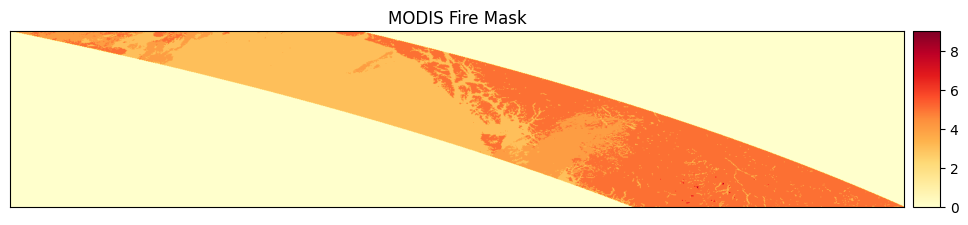

<Axes: title={'center': 'MODIS Fire Mask'}>

In [9]:
# Open data with rioxarray
modis_pre = rxr.open_rasterio(
    "/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.hdf"
)

modis_pre

# Convert the projection of the data
# print(modis_pre.rio.crs)

modis_pre.FireMask.rio.write_nodata(0, inplace=True)

modis_pre = modis_pre.FireMask.rio.reproject("EPSG:4326")

# print(modis_pre.rio.crs)


# Export the data
modis_pre.rio.to_raster(
    "/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.tif"
)

# Open the data with rasterio
modis_pre_2 = rasterio.open(
    "/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.tif"
)

modis_pre_2.profile

print(modis_pre_2.bounds)

# Plot the data
ep.plot_bands(modis_pre_2.read(1), cmap="YlOrRd", title="MODIS Fire Mask", scale=False)

## Rasterize modis_pre_2 to png with only the values 9

In [52]:
# Fire coordinates finder
coords = []

for i in range(0, modis_pre_2.read(1).shape[0]):
    for j in range(0, modis_pre_2.read(1).shape[1]):
        if modis_pre_2.read(1)[i, j] == 9:
            # Printing the coordinates of the pixel =9
            print("Fire Pixel at: ", modis_pre_2.xy(i, j))
            # Store the coordinates of the pixel =9
            coords.append(modis_pre_2.xy(i, j))


# Create a map centered on the mean of the coordinates
m = folium.Map(zoom_start=10)

# Add the coordinates to the map
for coord in coords:
    folium.Marker(location=[coord[1], coord[0]]).add_to(m)

# Display the map
m

Fire Pixel at:  (-119.69954537268181, 51.70059156998173)
Fire Pixel at:  (-121.57113100633222, 51.363092521290675)
Fire Pixel at:  (-121.54044927463303, 51.363092521290675)
Fire Pixel at:  (-119.30068286059239, 51.332410789591485)
Fire Pixel at:  (-119.2700011288932, 51.332410789591485)
Fire Pixel at:  (-119.33136459229158, 51.3017290578923)
Fire Pixel at:  (-119.30068286059239, 51.3017290578923)
Fire Pixel at:  (-119.2700011288932, 51.3017290578923)
Fire Pixel at:  (-118.93250208020214, 51.17900213109555)
Fire Pixel at:  (-120.74272425045417, 51.11763866769718)
Fire Pixel at:  (-120.74272425045417, 51.08695693599799)
Fire Pixel at:  (-118.93250208020214, 50.81082135070531)
Fire Pixel at:  (-118.90182034850295, 50.81082135070531)
Fire Pixel at:  (-121.1109050308444, 50.62673096051019)
Fire Pixel at:  (-121.08022329914522, 50.62673096051019)
Fire Pixel at:  (-121.04954156744604, 50.62673096051019)
Fire Pixel at:  (-119.82227229947856, 50.31991364351832)
Fire Pixel at:  (-121.23363195764

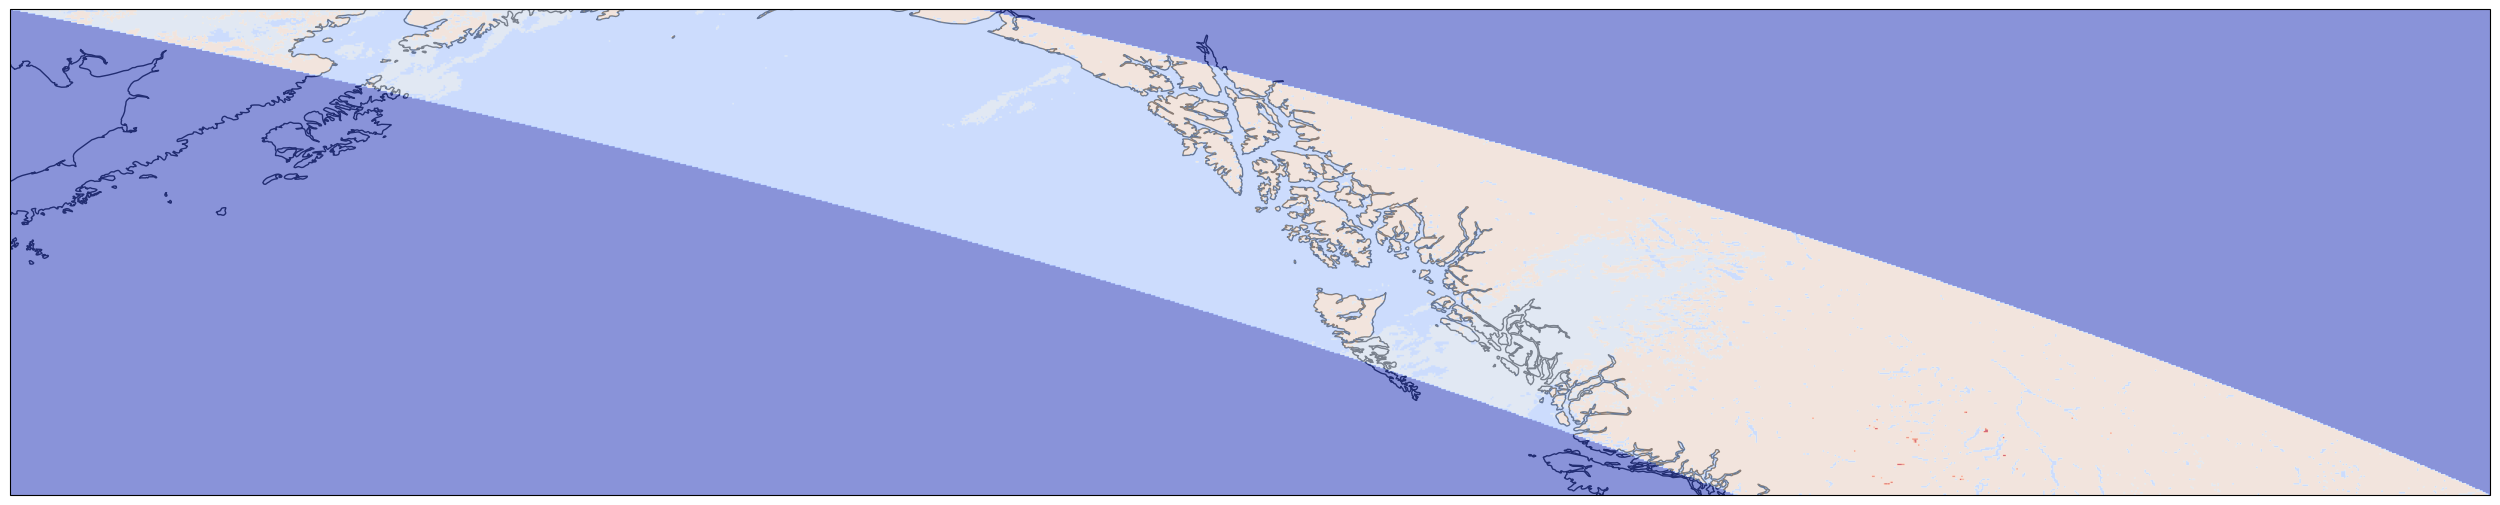

In [5]:
# Open the GeoTIFF file
image_path = '/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.tif'
image = georaster.SingleBandRaster(image_path, latlon=True)

# Create a figure and axis with PlateCarree projection
fig = plt.figure(figsize=(32, 32))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the GeoTIFF data
plt.imshow(image.r, extent=image.extent, transform=ccrs.PlateCarree(), zorder=2, alpha=0.6, cmap='coolwarm')

# Add coastlines and gridlines
ax.coastlines()

# Show the plot
plt.show()

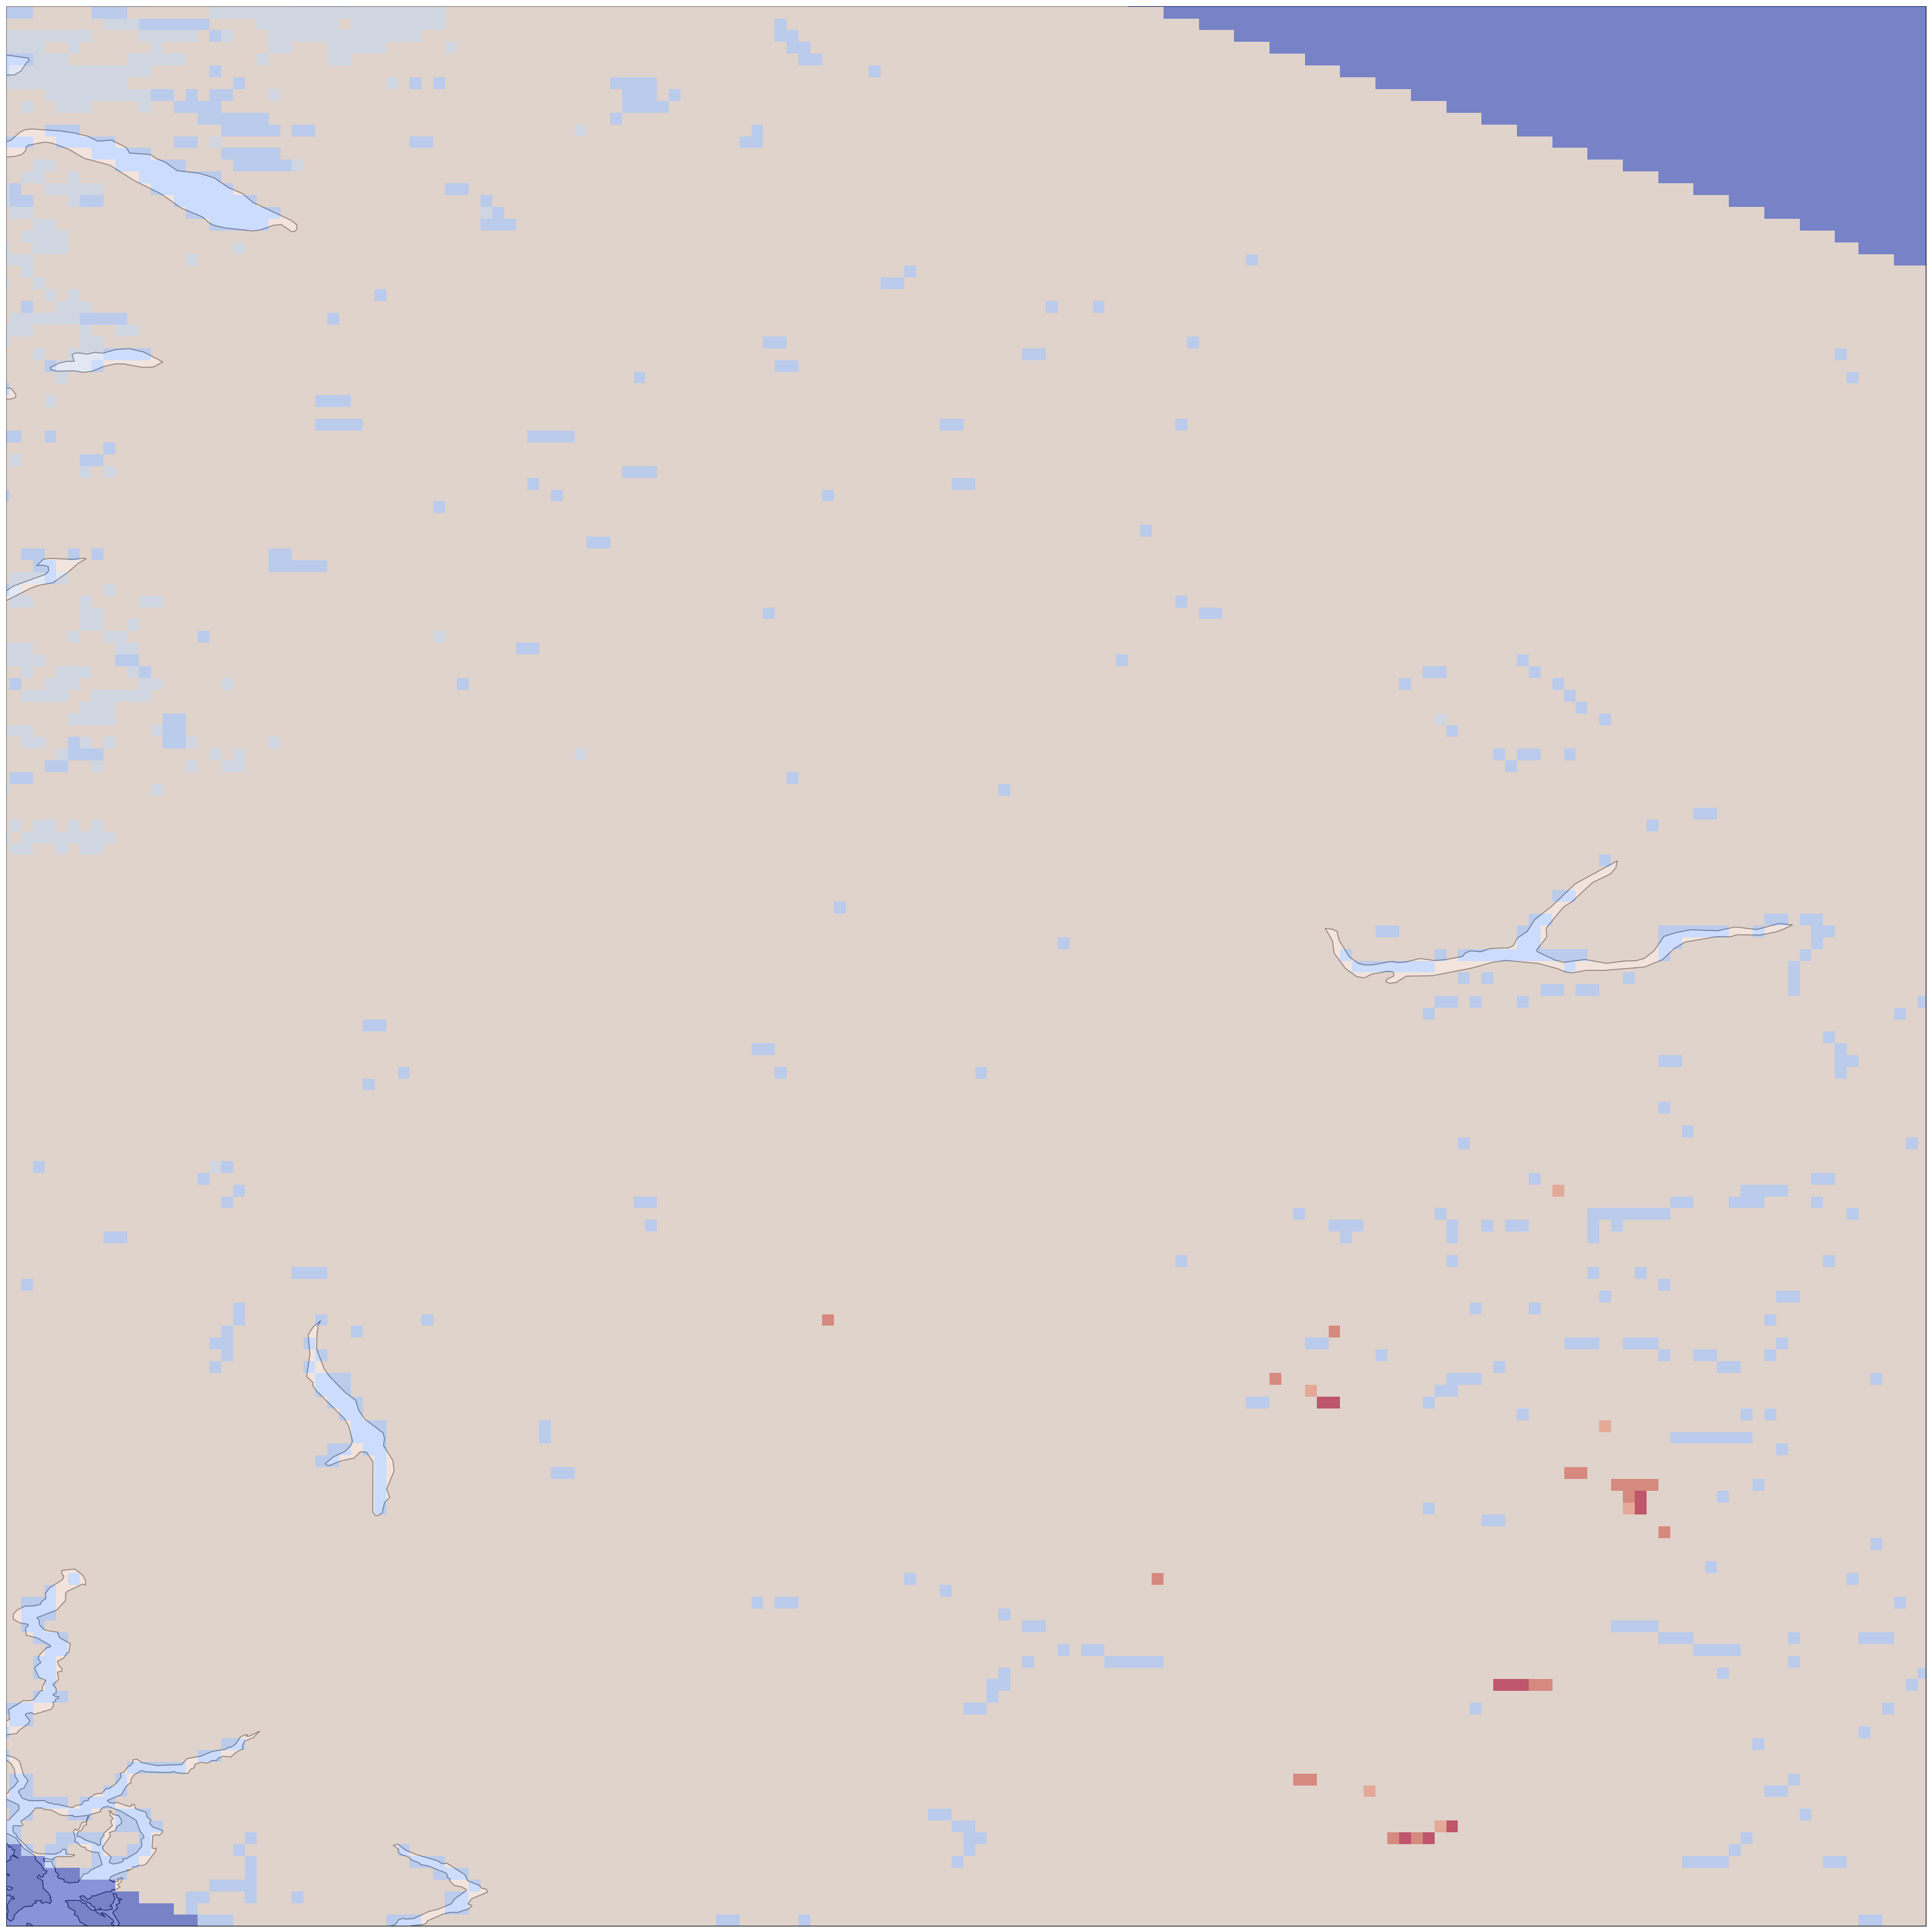

In [6]:
fig = plt.figure(figsize=(40,40))

m = Basemap(projection='cyl', lon_0=-134, lat_0=55, \
            llcrnrlat=50,urcrnrlat=55,\
            llcrnrlon=-125,urcrnrlon=-120, resolution='h')

m.drawcoastlines()
m.fillcontinents(color='lightgray')

image = georaster.SingleBandRaster( "/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.tif", latlon=False)

# Calculate the center of the image
center_lon = (image.extent[0] + image.extent[1]) / 2
center_lat = (image.extent[2] + image.extent[3]) / 2

plt.imshow(image.r, extent=image.extent+(2,2,2,2), zorder=10, alpha=0.6, cmap='coolwarm')

plt.show()

In [16]:
modis_pre = rxr.open_rasterio("/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.tiff")
modis_pre.rio.bounds()


(-159.99999995956395,
 49.99775546067685,
 -108.91491668041758,
 59.99999999461182)

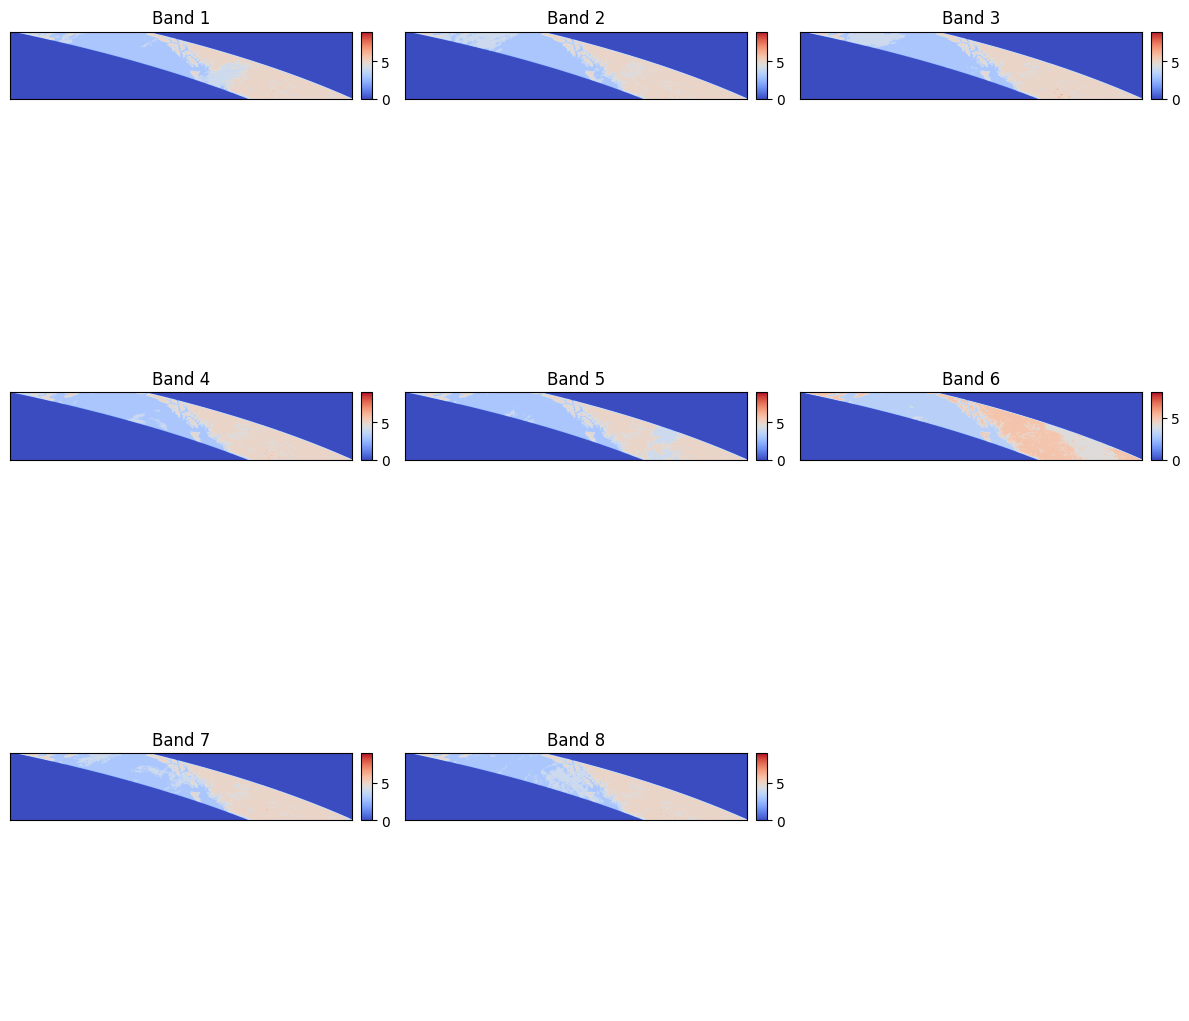

In [27]:
# for every band use a color map from black to blue to red
ep.plot_bands(modis_pre, cmap='coolwarm', scale=False)
plt.show()

# DOWNLOAD WEATHER DATA

In [54]:
## Invert the coordinates of coords, put the second element first and the first element second
coords = [(coord[1], coord[0]) for coord in coords]

# Create a df with the coords
df = pd.DataFrame(coords, columns=["latitude", "longitude"])

# Print the 2nd row
print(df.iloc[1])

latitude    -121.571131
longitude     51.363093
Name: 1, dtype: float64


Point index:  0


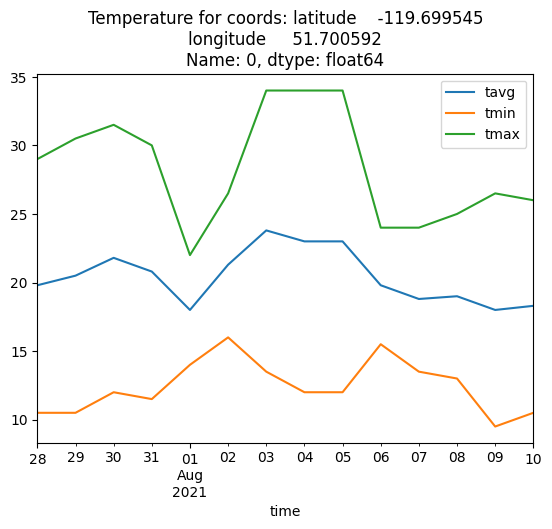

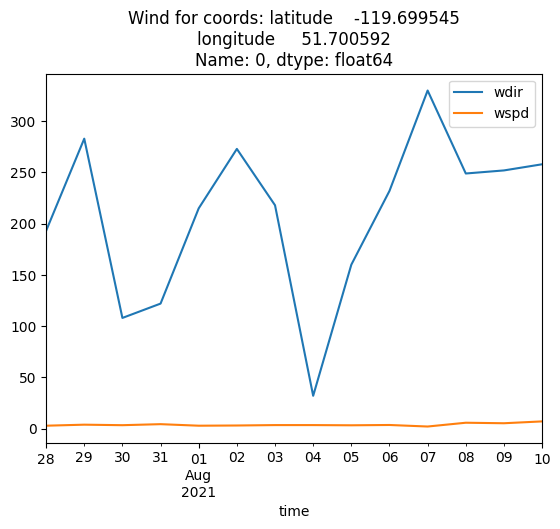

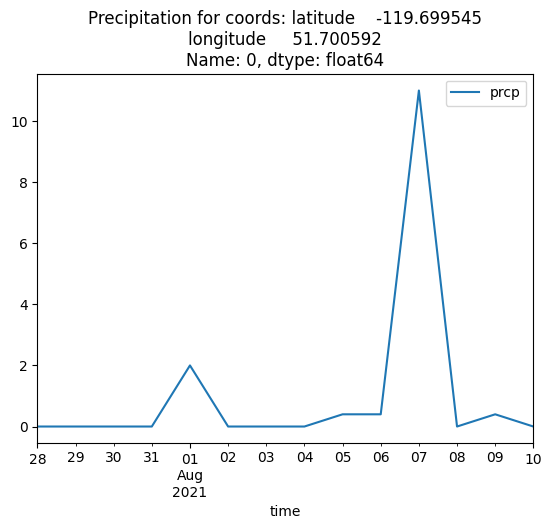

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-07-28  19.8  10.5  29.0   0.0   0.0  193.0   2.8   NaN  1016.6   NaN
2021-07-29  20.5  10.5  30.5   0.0   0.0  283.0   3.8   NaN  1015.8   NaN
2021-07-30  21.8  12.0  31.5   0.0   0.0  108.0   3.3   NaN  1016.1   NaN
2021-07-31  20.8  11.5  30.0   0.0   0.0  122.0   4.3   NaN  1017.3   NaN
2021-08-01  18.0  14.0  22.0   2.0   0.0  215.0   2.8   NaN  1018.5   NaN
2021-08-02  21.3  16.0  26.5   0.0   0.0  273.0   3.0   NaN  1018.1   NaN
2021-08-03  23.8  13.5  34.0   0.0   0.0  218.0   3.4   NaN  1015.7   NaN
2021-08-04  23.0  12.0  34.0   0.0   0.0   32.0   3.4   NaN  1012.8   NaN
2021-08-05  23.0  12.0  34.0   0.4   0.0  160.0   3.2   NaN  1008.2   NaN
2021-08-06  19.8  15.5  24.0   0.4   0.0  232.0   3.5   NaN  1010.0   NaN
2021-08-07  18.8  13.5  24.0  11.0   0.0  330.0   2.0   NaN  1008.6   NaN
2021-08-08  19.0  13.0  25.0   0.0   0

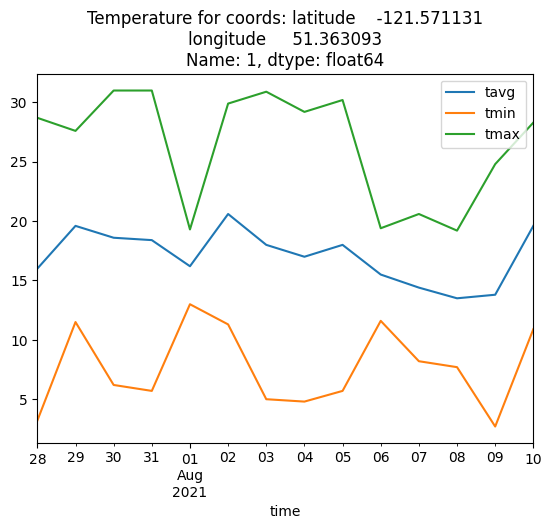

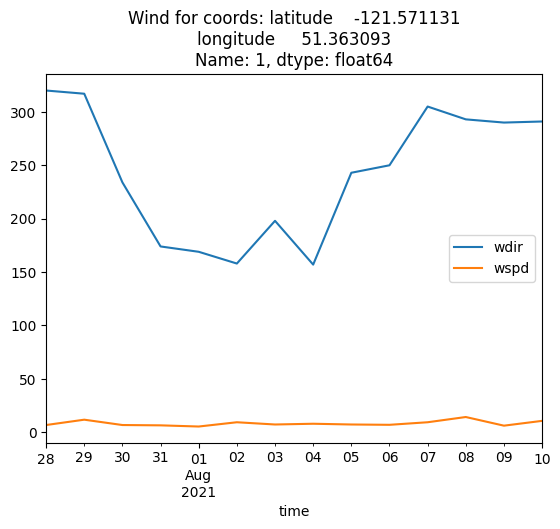

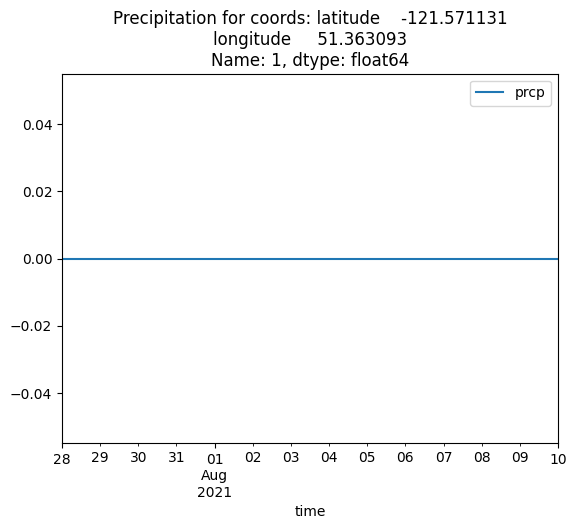

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-07-28  16.0   3.2  28.7   0.0   NaN  320.0   6.8   NaN  1016.9   NaN
2021-07-29  19.6  11.5  27.6   0.0   NaN  317.0  11.8  37.0  1016.0   NaN
2021-07-30  18.6   6.2  31.0   0.0   NaN  234.0   6.8  33.0  1016.1   NaN
2021-07-31  18.4   5.7  31.0   0.0   NaN  174.0   6.5  41.0  1017.9   NaN
2021-08-01  16.2  13.0  19.3   0.0   NaN  169.0   5.4   NaN  1018.6   NaN
2021-08-02  20.6  11.3  29.9   0.0   NaN  158.0   9.4   NaN  1016.5   NaN
2021-08-03  18.0   5.0  30.9   0.0   NaN  198.0   7.3  41.0  1014.9   NaN
2021-08-04  17.0   4.8  29.2   0.0   NaN  157.0   8.0   NaN  1012.6   NaN
2021-08-05  18.0   5.7  30.2   0.0   NaN  243.0   7.3  37.0  1008.0   NaN
2021-08-06  15.5  11.6  19.4   0.0   NaN  250.0   7.0  32.0  1009.8   NaN
2021-08-07  14.4   8.2  20.6   0.0   NaN  305.0   9.4  50.0  1007.7   NaN
2021-08-08  13.5   7.7  19.2   0.0   N

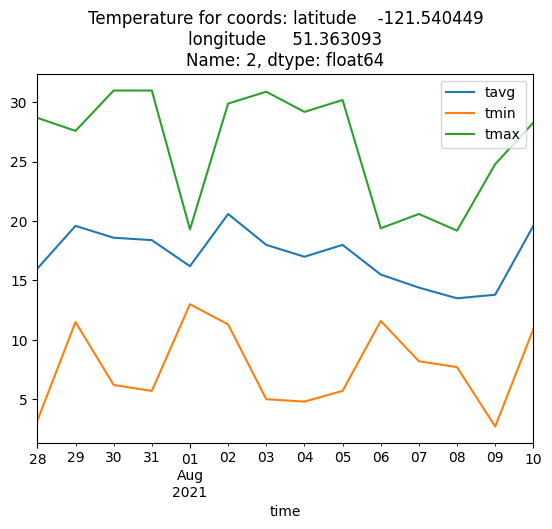

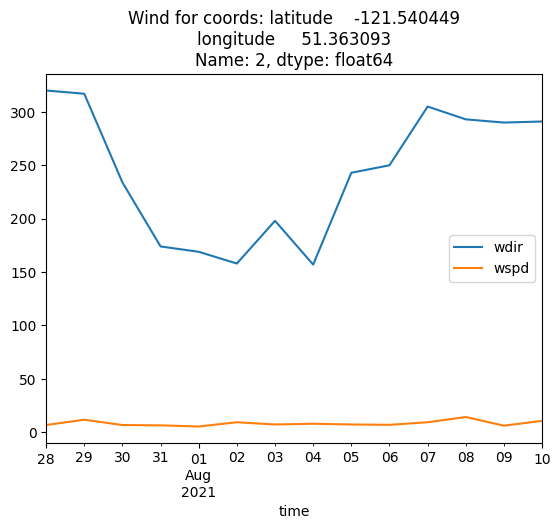

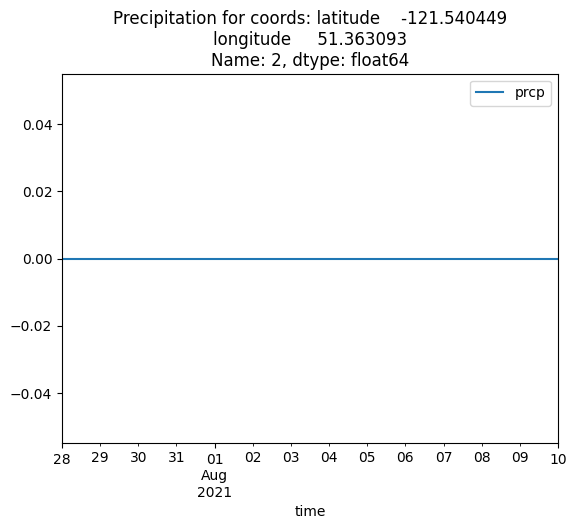

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-07-28  16.0   3.2  28.7   0.0   NaN  320.0   6.8   NaN  1016.9   NaN
2021-07-29  19.6  11.5  27.6   0.0   NaN  317.0  11.8  37.0  1016.0   NaN
2021-07-30  18.6   6.2  31.0   0.0   NaN  234.0   6.8  33.0  1016.1   NaN
2021-07-31  18.4   5.7  31.0   0.0   NaN  174.0   6.5  41.0  1017.9   NaN
2021-08-01  16.2  13.0  19.3   0.0   NaN  169.0   5.4   NaN  1018.6   NaN
2021-08-02  20.6  11.3  29.9   0.0   NaN  158.0   9.4   NaN  1016.5   NaN
2021-08-03  18.0   5.0  30.9   0.0   NaN  198.0   7.3  41.0  1014.9   NaN
2021-08-04  17.0   4.8  29.2   0.0   NaN  157.0   8.0   NaN  1012.6   NaN
2021-08-05  18.0   5.7  30.2   0.0   NaN  243.0   7.3  37.0  1008.0   NaN
2021-08-06  15.5  11.6  19.4   0.0   NaN  250.0   7.0  32.0  1009.8   NaN
2021-08-07  14.4   8.2  20.6   0.0   NaN  305.0   9.4  50.0  1007.7   NaN
2021-08-08  13.5   7.7  19.2   0.0   N

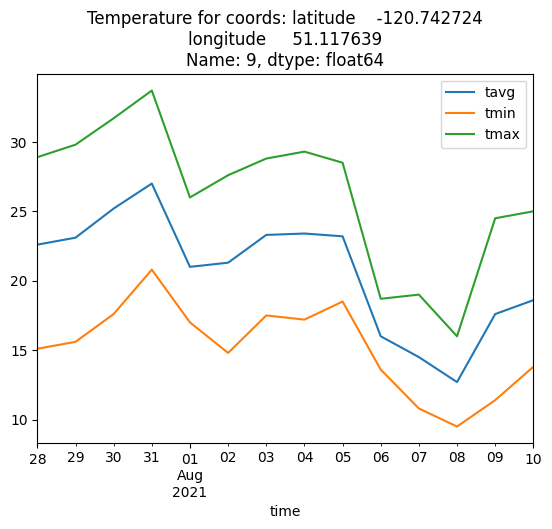

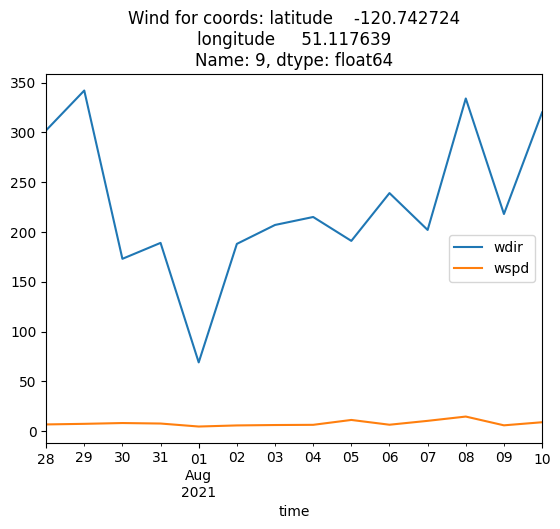

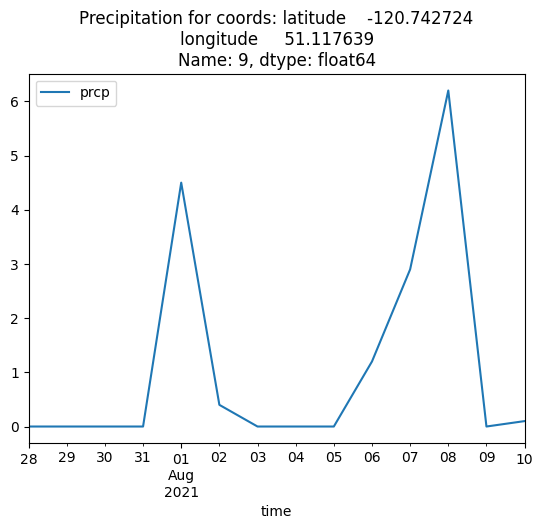

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-07-28  22.6  15.1  28.9   0.0   NaN  302.0   6.7   NaN  1017.7   NaN
2021-07-29  23.1  15.6  29.8   0.0   NaN  342.0   7.3   NaN  1017.2   NaN
2021-07-30  25.2  17.6  31.7   0.0   NaN  173.0   8.1   NaN  1017.0   NaN
2021-07-31  27.0  20.8  33.7   0.0   NaN  189.0   7.6   NaN  1018.2   NaN
2021-08-01  21.0  17.0  26.0   4.5   NaN   69.0   4.6   NaN  1019.3   NaN
2021-08-02  21.3  14.8  27.6   0.4   NaN  188.0   5.7   NaN  1018.5   NaN
2021-08-03  23.3  17.5  28.8   0.0   NaN  207.0   6.1   NaN  1016.6   NaN
2021-08-04  23.4  17.2  29.3   0.0   NaN  215.0   6.3   NaN  1013.7   NaN
2021-08-05  23.2  18.5  28.5   0.0   NaN  191.0  11.2   NaN  1009.7   NaN
2021-08-06  16.0  13.6  18.7   1.2   NaN  239.0   6.4   NaN  1011.2   NaN
2021-08-07  14.5  10.8  19.0   2.9   NaN  202.0  10.3   NaN  1009.0   NaN
2021-08-08  12.7   9.5  16.0   6.2   N

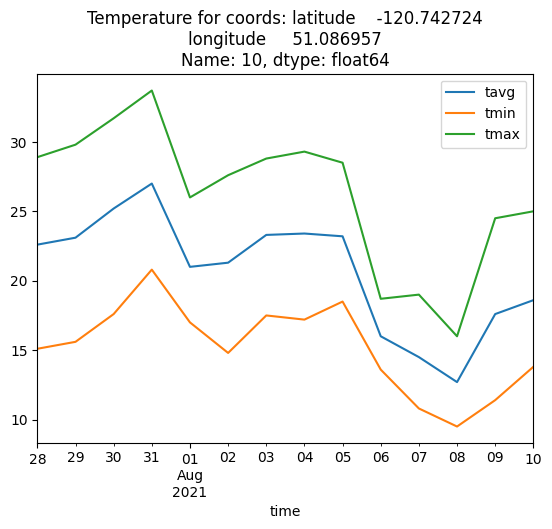

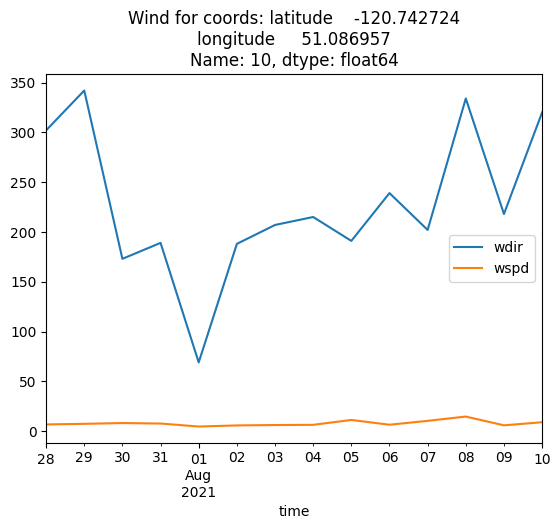

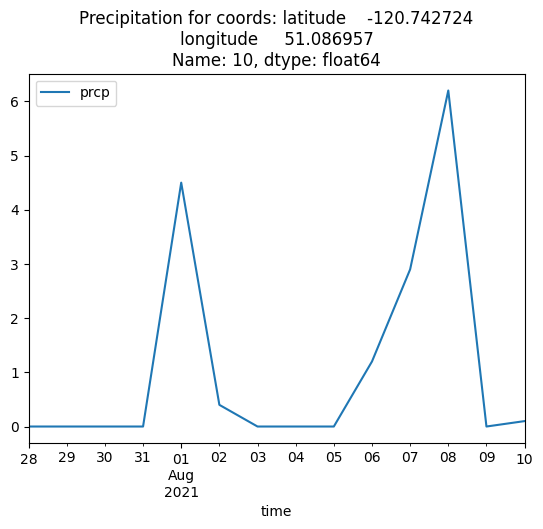

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-07-28  22.6  15.1  28.9   0.0   NaN  302.0   6.7   NaN  1017.7   NaN
2021-07-29  23.1  15.6  29.8   0.0   NaN  342.0   7.3   NaN  1017.2   NaN
2021-07-30  25.2  17.6  31.7   0.0   NaN  173.0   8.1   NaN  1017.0   NaN
2021-07-31  27.0  20.8  33.7   0.0   NaN  189.0   7.6   NaN  1018.2   NaN
2021-08-01  21.0  17.0  26.0   4.5   NaN   69.0   4.6   NaN  1019.3   NaN
2021-08-02  21.3  14.8  27.6   0.4   NaN  188.0   5.7   NaN  1018.5   NaN
2021-08-03  23.3  17.5  28.8   0.0   NaN  207.0   6.1   NaN  1016.6   NaN
2021-08-04  23.4  17.2  29.3   0.0   NaN  215.0   6.3   NaN  1013.7   NaN
2021-08-05  23.2  18.5  28.5   0.0   NaN  191.0  11.2   NaN  1009.7   NaN
2021-08-06  16.0  13.6  18.7   1.2   NaN  239.0   6.4   NaN  1011.2   NaN
2021-08-07  14.5  10.8  19.0   2.9   NaN  202.0  10.3   NaN  1009.0   NaN
2021-08-08  12.7   9.5  16.0   6.2   N

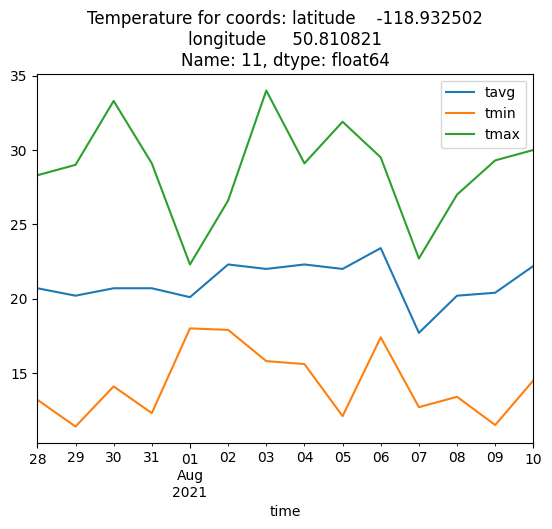

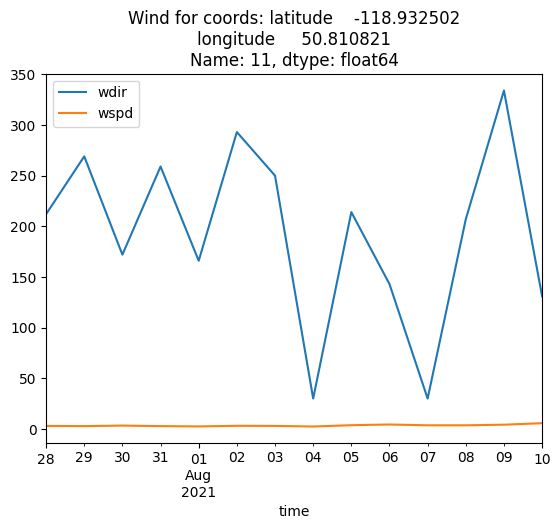

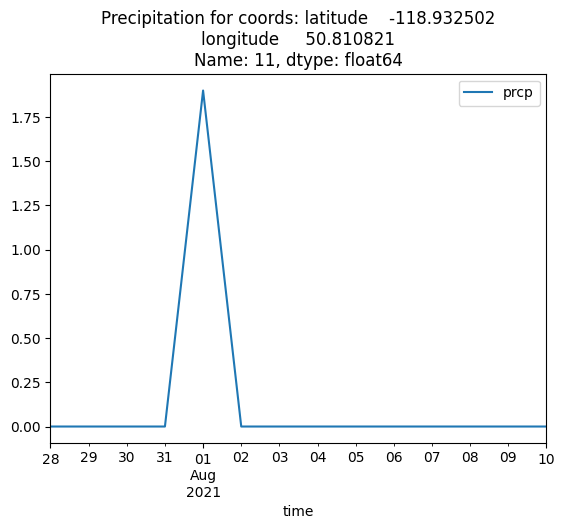

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-07-28  20.7  13.2  28.3   0.0   NaN  212.0   3.0   NaN  1016.5   NaN
2021-07-29  20.2  11.4  29.0   0.0   NaN  269.0   2.8   NaN  1015.8   NaN
2021-07-30  20.7  14.1  33.3   0.0   NaN  172.0   3.3   NaN  1015.8   NaN
2021-07-31  20.7  12.3  29.1   0.0   NaN  259.0   2.8   NaN  1016.3   NaN
2021-08-01  20.1  18.0  22.3   1.9   NaN  166.0   2.5   NaN  1017.0   NaN
2021-08-02  22.3  17.9  26.6   0.0   NaN  293.0   3.1   NaN  1018.2   NaN
2021-08-03  22.0  15.8  34.0   0.0   NaN  250.0   3.0   NaN  1015.3   NaN
2021-08-04  22.3  15.6  29.1   0.0   NaN   30.0   2.4   NaN  1012.7   NaN
2021-08-05  22.0  12.1  31.9   0.0   NaN  214.0   3.7   NaN  1008.1   NaN
2021-08-06  23.4  17.4  29.5   0.0   NaN  143.0   4.4  33.0  1007.9   NaN
2021-08-07  17.7  12.7  22.7   0.0   NaN   30.0   3.6   NaN  1008.0   NaN
2021-08-08  20.2  13.4  27.0   0.0   N

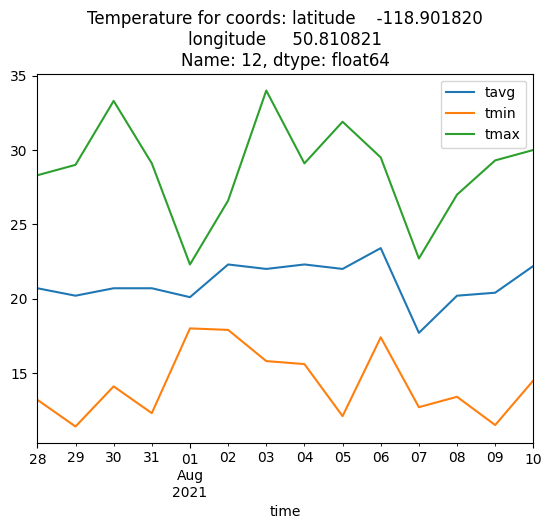

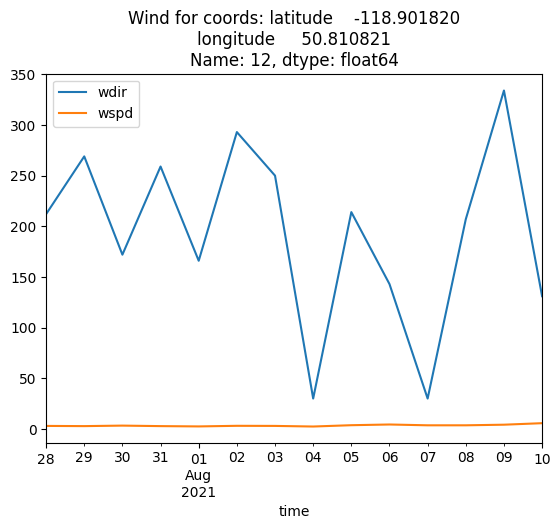

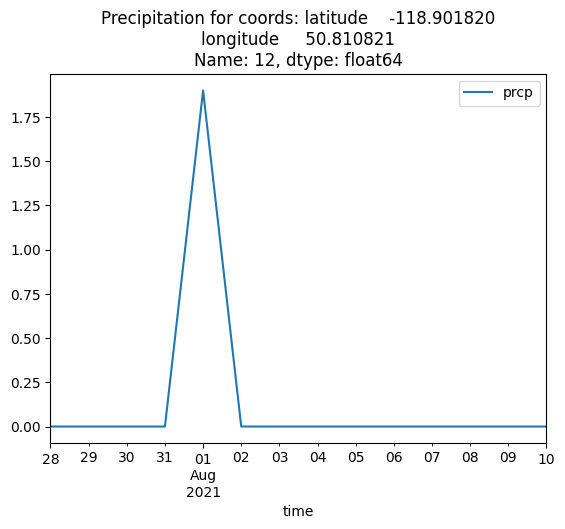

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-07-28  20.7  13.2  28.3   0.0   NaN  212.0   3.0   NaN  1016.5   NaN
2021-07-29  20.2  11.4  29.0   0.0   NaN  269.0   2.8   NaN  1015.8   NaN
2021-07-30  20.7  14.1  33.3   0.0   NaN  172.0   3.3   NaN  1015.8   NaN
2021-07-31  20.7  12.3  29.1   0.0   NaN  259.0   2.8   NaN  1016.3   NaN
2021-08-01  20.1  18.0  22.3   1.9   NaN  166.0   2.5   NaN  1017.0   NaN
2021-08-02  22.3  17.9  26.6   0.0   NaN  293.0   3.1   NaN  1018.2   NaN
2021-08-03  22.0  15.8  34.0   0.0   NaN  250.0   3.0   NaN  1015.3   NaN
2021-08-04  22.3  15.6  29.1   0.0   NaN   30.0   2.4   NaN  1012.7   NaN
2021-08-05  22.0  12.1  31.9   0.0   NaN  214.0   3.7   NaN  1008.1   NaN
2021-08-06  23.4  17.4  29.5   0.0   NaN  143.0   4.4  33.0  1007.9   NaN
2021-08-07  17.7  12.7  22.7   0.0   NaN   30.0   3.6   NaN  1008.0   NaN
2021-08-08  20.2  13.4  27.0   0.0   N

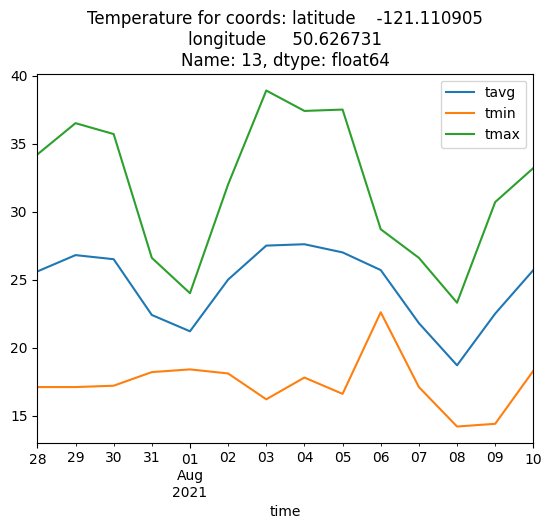

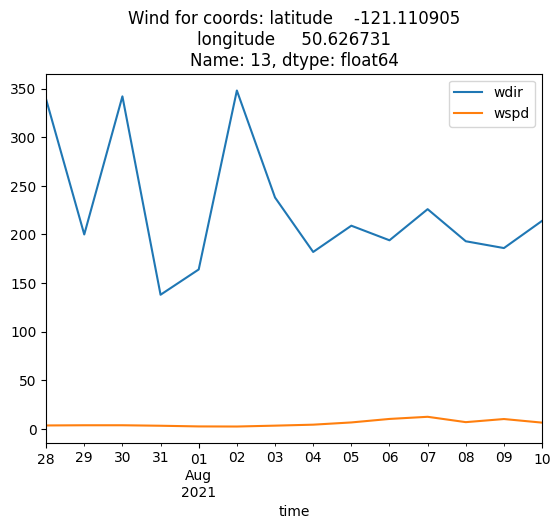

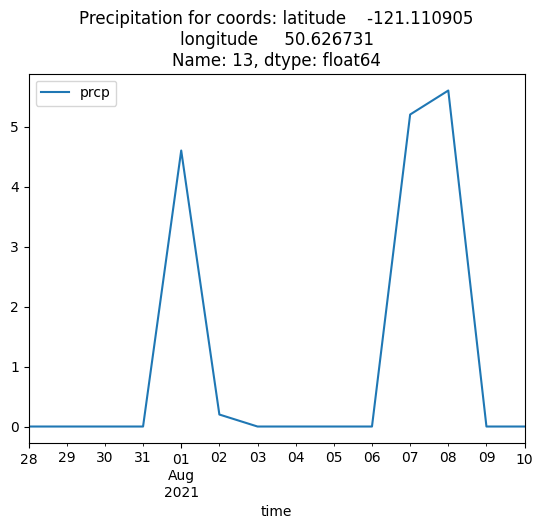

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-07-28  25.6  17.1  34.2   0.0   NaN  339.0   3.6   NaN  1015.5   NaN
2021-07-29  26.8  17.1  36.5   0.0   NaN  200.0   3.8   NaN  1014.9   NaN
2021-07-30  26.5  17.2  35.7   0.0   NaN  342.0   3.8   NaN  1014.8   NaN
2021-07-31  22.4  18.2  26.6   0.0   NaN  138.0   3.3   NaN  1017.5   NaN
2021-08-01  21.2  18.4  24.0   4.6   NaN  164.0   2.6   NaN  1018.5   NaN
2021-08-02  25.0  18.1  32.0   0.2   NaN  348.0   2.5   NaN  1017.3   NaN
2021-08-03  27.5  16.2  38.9   0.0   NaN  238.0   3.4   NaN  1014.2   NaN
2021-08-04  27.6  17.8  37.4   0.0   NaN  182.0   4.4   NaN  1011.4   NaN
2021-08-05  27.0  16.6  37.5   0.0   NaN  209.0   6.7   NaN  1007.2   NaN
2021-08-06  25.7  22.6  28.7   0.0   NaN  194.0  10.3  35.0  1007.8   NaN
2021-08-07  21.8  17.1  26.6   5.2   NaN  226.0  12.5  36.0  1007.0   NaN
2021-08-08  18.7  14.2  23.3   5.6   N

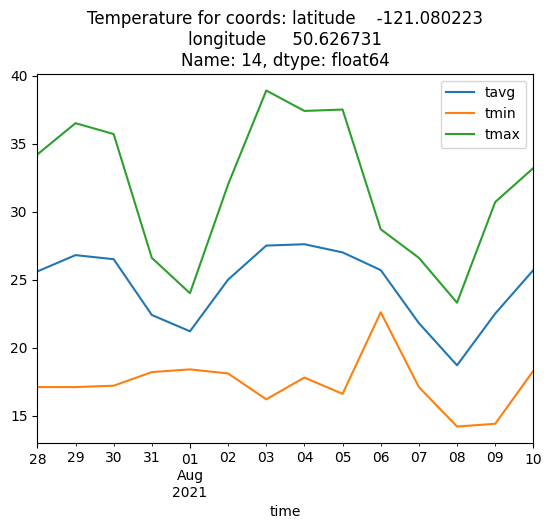

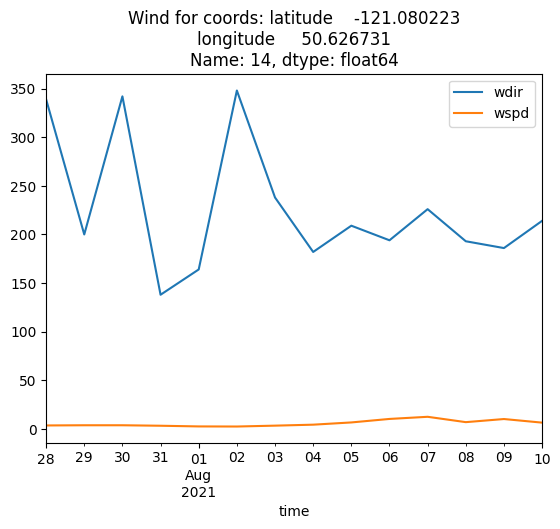

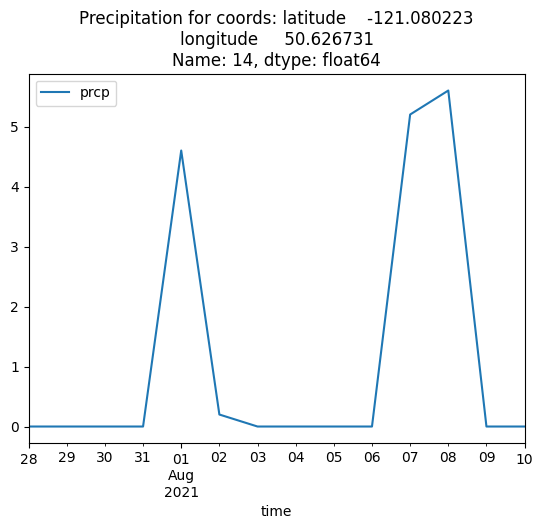

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-07-28  25.6  17.1  34.2   0.0   NaN  339.0   3.6   NaN  1015.5   NaN
2021-07-29  26.8  17.1  36.5   0.0   NaN  200.0   3.8   NaN  1014.9   NaN
2021-07-30  26.5  17.2  35.7   0.0   NaN  342.0   3.8   NaN  1014.8   NaN
2021-07-31  22.4  18.2  26.6   0.0   NaN  138.0   3.3   NaN  1017.5   NaN
2021-08-01  21.2  18.4  24.0   4.6   NaN  164.0   2.6   NaN  1018.5   NaN
2021-08-02  25.0  18.1  32.0   0.2   NaN  348.0   2.5   NaN  1017.3   NaN
2021-08-03  27.5  16.2  38.9   0.0   NaN  238.0   3.4   NaN  1014.2   NaN
2021-08-04  27.6  17.8  37.4   0.0   NaN  182.0   4.4   NaN  1011.4   NaN
2021-08-05  27.0  16.6  37.5   0.0   NaN  209.0   6.7   NaN  1007.2   NaN
2021-08-06  25.7  22.6  28.7   0.0   NaN  194.0  10.3  35.0  1007.8   NaN
2021-08-07  21.8  17.1  26.6   5.2   NaN  226.0  12.5  36.0  1007.0   NaN
2021-08-08  18.7  14.2  23.3   5.6   N

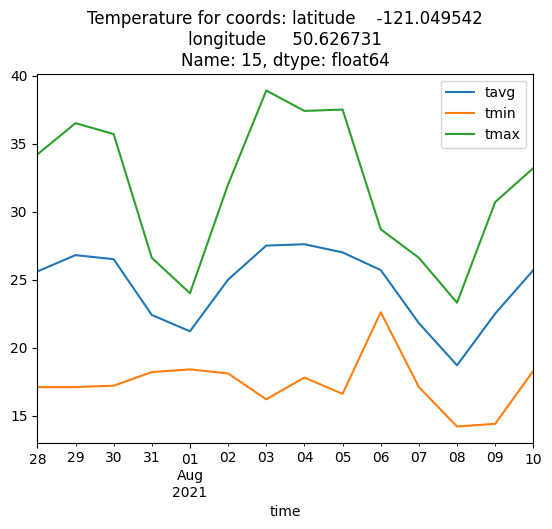

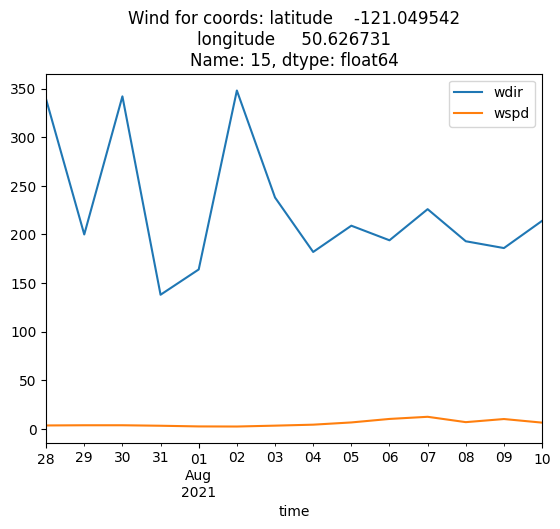

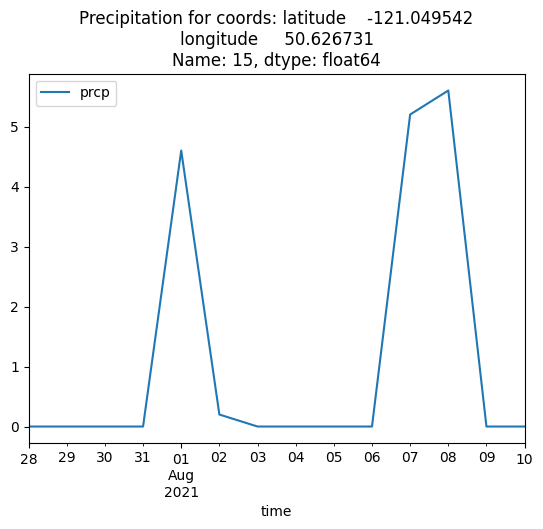

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-07-28  25.6  17.1  34.2   0.0   NaN  339.0   3.6   NaN  1015.5   NaN
2021-07-29  26.8  17.1  36.5   0.0   NaN  200.0   3.8   NaN  1014.9   NaN
2021-07-30  26.5  17.2  35.7   0.0   NaN  342.0   3.8   NaN  1014.8   NaN
2021-07-31  22.4  18.2  26.6   0.0   NaN  138.0   3.3   NaN  1017.5   NaN
2021-08-01  21.2  18.4  24.0   4.6   NaN  164.0   2.6   NaN  1018.5   NaN
2021-08-02  25.0  18.1  32.0   0.2   NaN  348.0   2.5   NaN  1017.3   NaN
2021-08-03  27.5  16.2  38.9   0.0   NaN  238.0   3.4   NaN  1014.2   NaN
2021-08-04  27.6  17.8  37.4   0.0   NaN  182.0   4.4   NaN  1011.4   NaN
2021-08-05  27.0  16.6  37.5   0.0   NaN  209.0   6.7   NaN  1007.2   NaN
2021-08-06  25.7  22.6  28.7   0.0   NaN  194.0  10.3  35.0  1007.8   NaN
2021-08-07  21.8  17.1  26.6   5.2   NaN  226.0  12.5  36.0  1007.0   NaN
2021-08-08  18.7  14.2  23.3   5.6   N

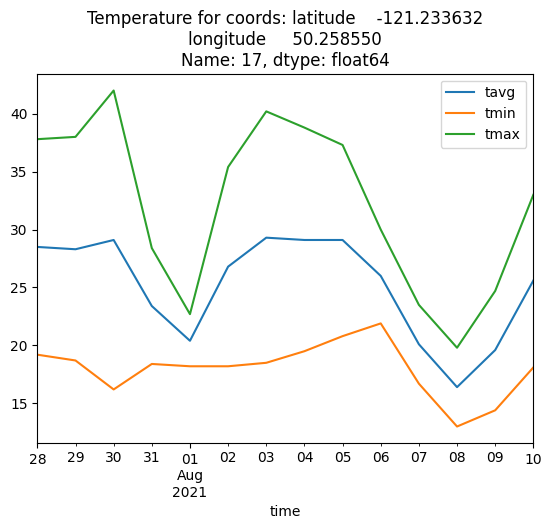

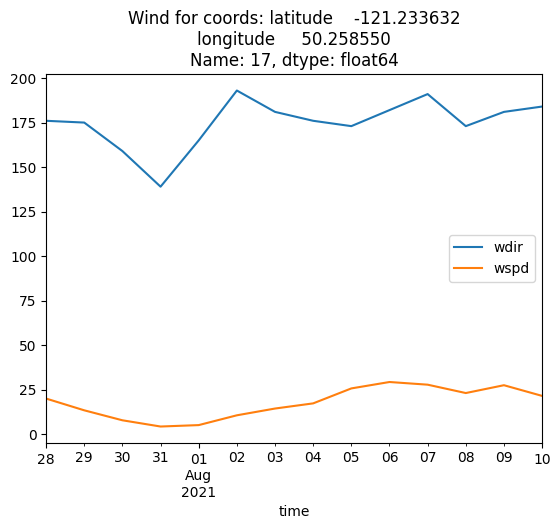

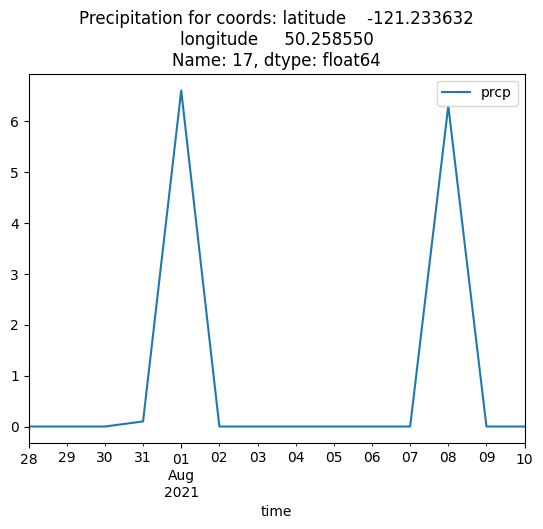

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-07-28  28.5  19.2  37.8   0.0   NaN  176.0  20.0  51.0  1014.8   NaN
2021-07-29  28.3  18.7  38.0   0.0   NaN  175.0  13.4  51.0  1014.3   NaN
2021-07-30  29.1  16.2  42.0   0.0   NaN  159.0   7.8  49.0  1013.6   NaN
2021-07-31  23.4  18.4  28.4   0.1   NaN  139.0   4.3   NaN  1016.7   NaN
2021-08-01  20.4  18.2  22.7   6.6   NaN  165.0   5.1  35.0  1018.4   NaN
2021-08-02  26.8  18.2  35.4   0.0   NaN  193.0  10.6  57.0  1016.6   NaN
2021-08-03  29.3  18.5  40.2   0.0   NaN  181.0  14.4  47.0  1013.4   NaN
2021-08-04  29.1  19.5  38.8   0.0   NaN  176.0  17.3  50.0  1010.7   NaN
2021-08-05  29.1  20.8  37.3   0.0   NaN  173.0  25.7  67.0  1007.0   NaN
2021-08-06  26.0  21.9  30.0   0.0   NaN  182.0  29.3  74.0  1008.6   NaN
2021-08-07  20.1  16.7  23.5   0.0   NaN  191.0  27.8  61.0  1008.0   NaN
2021-08-08  16.4  13.0  19.8   6.3   N

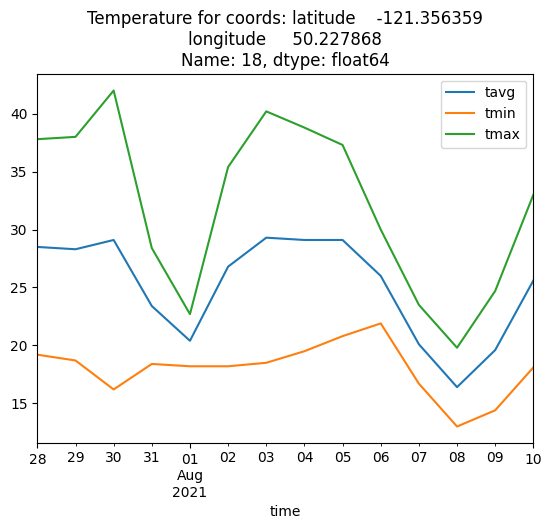

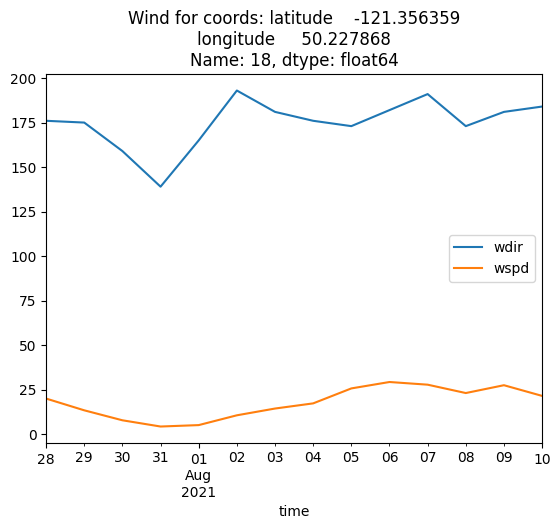

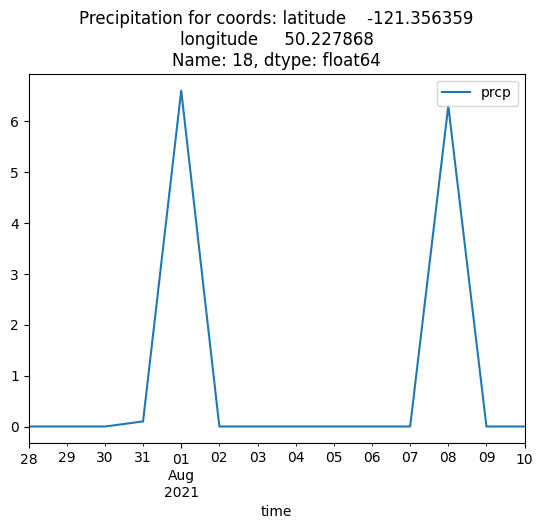

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-07-28  28.5  19.2  37.8   0.0   NaN  176.0  20.0  51.0  1014.8   NaN
2021-07-29  28.3  18.7  38.0   0.0   NaN  175.0  13.4  51.0  1014.3   NaN
2021-07-30  29.1  16.2  42.0   0.0   NaN  159.0   7.8  49.0  1013.6   NaN
2021-07-31  23.4  18.4  28.4   0.1   NaN  139.0   4.3   NaN  1016.7   NaN
2021-08-01  20.4  18.2  22.7   6.6   NaN  165.0   5.1  35.0  1018.4   NaN
2021-08-02  26.8  18.2  35.4   0.0   NaN  193.0  10.6  57.0  1016.6   NaN
2021-08-03  29.3  18.5  40.2   0.0   NaN  181.0  14.4  47.0  1013.4   NaN
2021-08-04  29.1  19.5  38.8   0.0   NaN  176.0  17.3  50.0  1010.7   NaN
2021-08-05  29.1  20.8  37.3   0.0   NaN  173.0  25.7  67.0  1007.0   NaN
2021-08-06  26.0  21.9  30.0   0.0   NaN  182.0  29.3  74.0  1008.6   NaN
2021-08-07  20.1  16.7  23.5   0.0   NaN  191.0  27.8  61.0  1008.0   NaN
2021-08-08  16.4  13.0  19.8   6.3   N

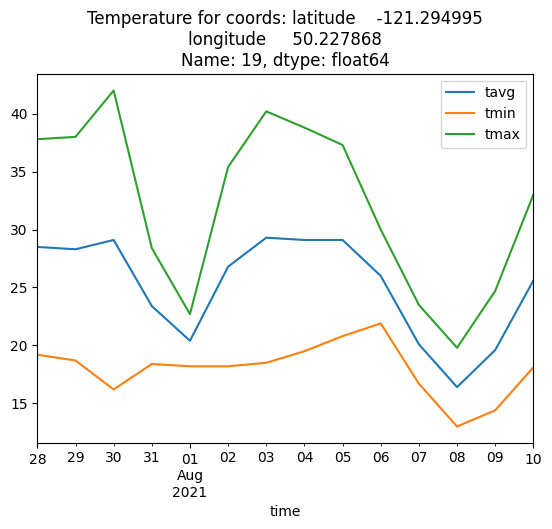

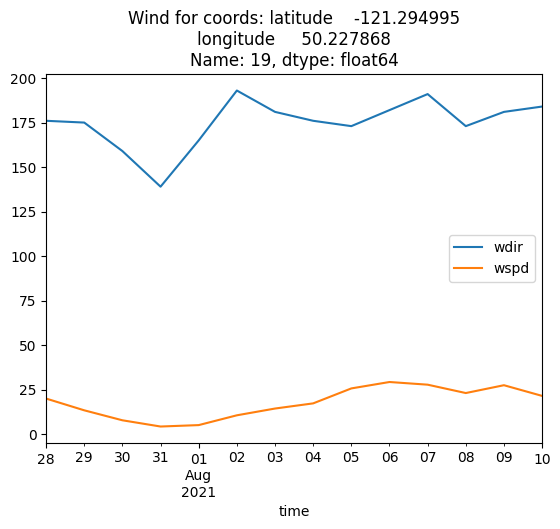

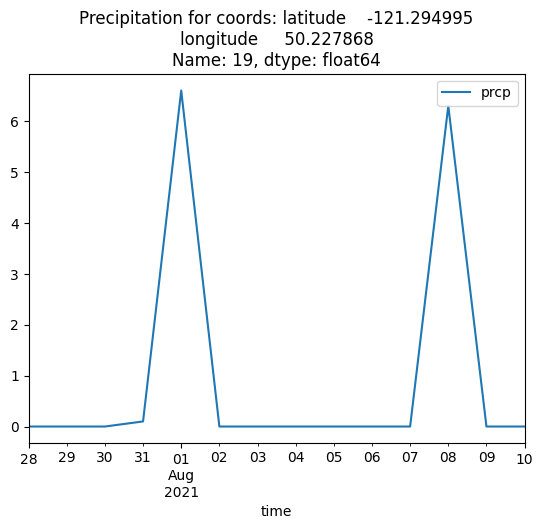

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-07-28  28.5  19.2  37.8   0.0   NaN  176.0  20.0  51.0  1014.8   NaN
2021-07-29  28.3  18.7  38.0   0.0   NaN  175.0  13.4  51.0  1014.3   NaN
2021-07-30  29.1  16.2  42.0   0.0   NaN  159.0   7.8  49.0  1013.6   NaN
2021-07-31  23.4  18.4  28.4   0.1   NaN  139.0   4.3   NaN  1016.7   NaN
2021-08-01  20.4  18.2  22.7   6.6   NaN  165.0   5.1  35.0  1018.4   NaN
2021-08-02  26.8  18.2  35.4   0.0   NaN  193.0  10.6  57.0  1016.6   NaN
2021-08-03  29.3  18.5  40.2   0.0   NaN  181.0  14.4  47.0  1013.4   NaN
2021-08-04  29.1  19.5  38.8   0.0   NaN  176.0  17.3  50.0  1010.7   NaN
2021-08-05  29.1  20.8  37.3   0.0   NaN  173.0  25.7  67.0  1007.0   NaN
2021-08-06  26.0  21.9  30.0   0.0   NaN  182.0  29.3  74.0  1008.6   NaN
2021-08-07  20.1  16.7  23.5   0.0   NaN  191.0  27.8  61.0  1008.0   NaN
2021-08-08  16.4  13.0  19.8   6.3   N

In [72]:
# Set time period
start = datetime(2021, 7, 28)
end = datetime(2021, 8, 10)

# Create a point
coords2 = [Point(coord[1], coord[0]) for coord in coords]


for point in coords2:
    # print the index of the point in the dataframe
    print("Point index: ", coords2.index(point))
    # Get daily data
    data = Daily(point, start, end)
    data = data.fetch()

    if data.empty:
        continue
    # Put the corresponding coords in the legend

    data.plot(y=["tavg", "tmin", "tmax"])
    # Name the plot after the coords corresponding to the point index inside df dataframe
    plt.title(f"Temperature for coords: {df.iloc[coords2.index(point)]}")
    plt.show()

    # Plot the wind direciton data for the point
    data.plot(y=["wdir", "wspd"])
    plt.title(f"Wind for coords: {df.iloc[coords2.index(point)]}")
    plt.show()

    # Plot precipitation data for the point
    data.plot(y=["prcp"])
    plt.title(f"Precipitation for coords: {df.iloc[coords2.index(point)]}")
    plt.show()

    print(data)